# Project

In [43]:
import pandas as pd
import matplotlib.pyplot as plt


In [20]:
firstname_with_sex = pd.read_csv('firstname_with_sex.csv', sep=';')
transcriptions_with_sex = pd.read_csv('transcriptions_with_sex.csv', sep=',')
#transcriptions_with_sex = pd.read_csv('transcriptions_with_sex.csv', sep=';|:')

In [34]:
firstname_with_sex

,firstname,male,female
0,marie,10145,2390322
1,jean,1869615,6476
2,pierre,1475841,5047
3,jeanne,1765,1097397
4,françois,1089009,5951
...,...,...,...
6941,winnocq,10,0
6942,xyste,9,1
6943,zara,0,10
6944,zéraphin,10,0


In [33]:
firstname_with_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   firstname  6946 non-null   object
 1   male       6946 non-null   int64 
 2   female     6946 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 162.9+ KB


In [35]:
# A ratio closer to 1 means a name more used by males
firstname_with_sex['ratio'] = firstname_with_sex['male'] / (firstname_with_sex['male'] + firstname_with_sex['female'])

In [36]:
firstname_with_sex.head()

,firstname,male,female,ratio
0,marie,10145,2390322,0.004226
1,jean,1869615,6476,0.996548
2,pierre,1475841,5047,0.996592
3,jeanne,1765,1097397,0.001606
4,françois,1089009,5951,0.994565


In [46]:
fig, ax = plt.subplots(1, 2, sharey=False, tight_layout=True)

ax[0].hist(firstname_with_sex['ratio'], bins=20)
ax[1].hist(firstname_with_sex['ratio'], bins=20, range=(0.05, 0.95))
ax[0]

AttributeError: 'str' object has no attribute 'sticky_edges'

<AxesSubplot:>

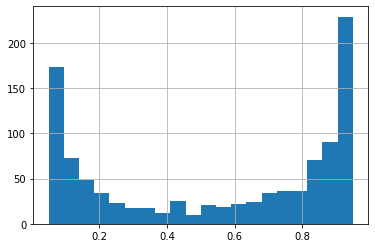

In [41]:
firstname_with_sex['ratio'].hist(bins=20, range=(0.05, 0.95),log=False)

In [52]:
transcriptions_with_sex.tail()

,subject_line,groundtruth,prediction,sex
236,1d92738a-cffe-4aee-ab10-db04c37f7405,surname: Burlurut firstname: Pétronille occupa...,nom: Burlurut prénom: Gihromille date_naissanc...,femme
237,09440055-7972-4135-a537-e6c5a1f2aeb2,surname: Combey firstname: Alexandre occupatio...,nom: Comberf prénom: Alexandre date_naissance:...,homme
238,4d387278-12c3-410c-bdf0-c5c603479764,surname: Collin firstname: Marguerite occupati...,nom: Collin prénom: Marguerite date_naissance:...,femme
239,623b95de-f87c-4844-a7f7-361088eed83a,surname: Dumont firstname: Etienne link: fils ...,nom: Dumont prénom: Etienne date_naissance: 19...,homme
240,26d7839c-16a1-486e-9736-83e500fb72e5,surname: Renaut firstname: Antoinette link: be...,nom: Renaut prénom: Antoinette date_naissance:...,femme


In [23]:
transcriptions_with_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject_line  241 non-null    object
 1   groundtruth   241 non-null    object
 2   prediction    241 non-null    object
 3   sex           241 non-null    object
dtypes: object(4)
memory usage: 7.7+ KB


In [50]:
groundtruth = transcriptions_with_sex['groundtruth'].str.split(' ')
prediction = transcriptions_with_sex['prediction'].str.split(' ')
groundtruth.head()
prediction.tail()

236    [nom:, Burlurut, prénom:, Gihromille, date_nai...
237    [nom:, Comberf, prénom:, Alexandre, date_naiss...
238    [nom:, Collin, prénom:, Marguerite, date_naiss...
239    [nom:, Dumont, prénom:, Etienne, date_naissanc...
240    [nom:, Renaut, prénom:, Antoinette, date_naiss...
Name: prediction, dtype: object

In [51]:
prediction = transcriptions_with_sex['prediction'].str.split(':')
prediction.tail()

236    [nom,  Burlurut prénom,  Gihromille date_naiss...
237    [nom,  Comberf prénom,  Alexandre date_naissan...
238    [nom,  Collin prénom,  Marguerite date_naissan...
239    [nom,  Dumont prénom,  Etienne date_naissance,...
240    [nom,  Renaut prénom,  Antoinette date_naissan...
Name: prediction, dtype: object

In [48]:
groundtruth.head()

0    [surname:, Chardon, firstname:, Marie, occupat...
1    [surname:, Lhopital, firstname:, Louis-Jean, o...
2    [surname:, Papin, firstname:, Marie, occupatio...
3    [surname:, Lavocat, firstname:, Marie, link:, ...
4    [surname:, Benne, firstname:, Marguerite, age:...
Name: groundtruth, dtype: object

In [53]:
# Initialize an empty dictionary
data_dicts = []

# Iterate over each list in the column
for row_list in groundtruth:
    # Initialize an empty dictionary for each row
    data_dict = {}
    # Iterate over the list in steps of 2
    for i in range(0, len(row_list), 2):
        # Extract column name and corresponding value
        column_name = row_list[i].strip(':')
        value = row_list[i+1]
        # Add the pair to the dictionary
        data_dict[column_name] = value
    # Append the dictionary to the list of dictionaries
    data_dicts.append(data_dict)

# Create DataFrame from the list of dictionaries
result_df = pd.DataFrame(data_dicts)
result_df

IndexError: list index out of range

In [29]:
df = pd.read_csv('transcriptions_with_sex.csv', sep=',')

# Define a function to extract information from the 'groundtruth' and 'prediction' columns
def extract_info(row):
    # Split the string based on ' ' and ':'
    info_pairs = row.split(' ')
    info_dict = {}
    for pair in info_pairs:
        if ':' in pair:
            key, value = pair.split(':')
            info_dict[key] = value.strip()
    return pd.Series(info_dict)

# Apply the function to 'groundtruth' and 'prediction' columns
df_groundtruth = df['groundtruth'].apply(extract_info)
df_prediction = df['prediction'].apply(extract_info)

# Rename the columns to avoid conflicts when merging
df_groundtruth.columns = ['groundtruth_' + col for col in df_groundtruth.columns]
df_prediction.columns = ['prediction_' + col for col in df_prediction.columns]

# Merge the extracted information with the original DataFrame
df = pd.concat([df, df_groundtruth, df_prediction], axis=1)


In [30]:
df.head()

,subject_line,groundtruth,prediction,sex,groundtruth_surname,groundtruth_firstname,groundtruth_occupation,groundtruth_link,groundtruth_age,groundtruth_employer,...,groundtruth_observation,prediction_nom,prediction_prénom,prediction_date_naissance,prediction_lieux_naissance,prediction_employeur,prediction_relation,prediction_profession,prediction_état_civil,prediction_éducation
0,ebb26ada-044c-4c62-9dbc-a9c8d505d31c,surname: Chardon firstname: Marie occupation: ...,nom: Chardon prénom: Marie date_naissance: 30 ...,femme,,,,,,NaN,...,NaN,,,,,NaN,NaN,NaN,NaN,NaN
1,338496f5-e4ca-43ac-aa5c-429cb3f6ac00,surname: Lhopital firstname: Louis-Jean occupa...,nom: Lhopital prénom: Louis Jean date_naissanc...,homme,,,,,,NaN,...,NaN,,,,,,NaN,NaN,NaN,NaN
2,e6a279da-9b6f-4f49-b498-64857bc50d1e,surname: Papin firstname: Marie occupation: id...,nom: Pyrin prénom: Marie date_naissance: 55 re...,femme,,,,,,,...,NaN,,,,NaN,NaN,,NaN,NaN,NaN
3,7534deca-39e8-4f00-be17-c12460015de1,surname: Lavocat firstname: Marie link: femme ...,nom: Lavocat prénom: Marie date_naissance: 187...,femme,,,NaN,,NaN,NaN,...,NaN,,,,,NaN,NaN,,NaN,NaN
4,ef334a66-a504-418a-9872-e7c9db923488,surname: Benne firstname: Marguerite age: 78,nom: Benne prénom: Marguerite date_naissance: ...,femme,,,NaN,NaN,,NaN,...,NaN,,,,,NaN,,NaN,NaN,NaN


In [32]:
import pandas as pd
import re

# Define the input strings
input_strings = [
    "surname: Chardon firstname: Marie occupation: idem link: fille age: 30",
    "surname: Lhopital firstname: Louis-Jean occupation: sp link: chef age: 67",
    "surname: Lavocat firstname: Marie link: femme birth_date: 1875 lob: Rigny"
]

# Define a function to extract key-value pairs from each string
def extract_info(s):
    info_dict = {}
    pairs = re.findall(r'(\w+):\s*([^:\n]+)', s)
    for key, value in pairs:
        info_dict[key.strip()] = value.strip()
    return info_dict

# Extract key-value pairs from each string and create a list of dictionaries
data = [extract_info(line) for line in input_strings]

# Create DataFrame
df = pd.DataFrame(data)

# Reorder columns if necessary
#df = df[['surname', 'firstname', 'occupation', 'link', 'age']]

# Print the DataFrame
print(df)

              surname occupation  age              link    lob
0   Chardon firstname  idem link   30               NaN    NaN
1  Lhopital firstname    sp link   67               NaN    NaN
2   Lavocat firstname        NaN  NaN  femme birth_date  Rigny
